In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ipywidgets as widgets

%matplotlib widget
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'y')

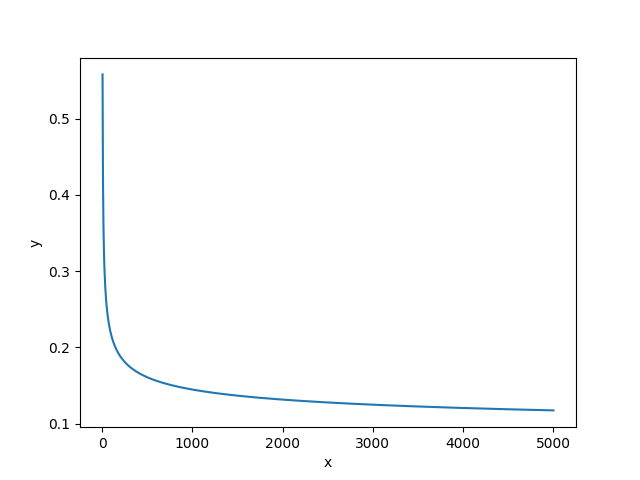

In [54]:
linspace = np.linspace(0, 5000, 1000)
x = torch.tensor(linspace, requires_grad=False)
y = 1/torch.log(x+1)

fig, ax = plt.subplots()
ax.plot(linspace, y.numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')


In [48]:
# batch, player, position(x, y)
team = torch.tensor([[[1, 2], [3, 4]], [[7, 8], [9, 10]]]).float()
target = (1, 2)
target_torch = torch.tensor(target).repeat(team.shape[0], 1).unsqueeze(1).float()
print(team.shape, target_torch.shape)

norm = torch.norm(team - target_torch, dim=2)
print(norm)

torch.Size([2, 2, 2]) torch.Size([2, 1, 2])
tensor([[ 0.0000,  2.8284],
        [ 8.4853, 11.3137]])


In [52]:
torch.mean(norm, dim=1)

tensor([1.4142, 9.8995])

In [8]:
scaling = (norm)
foo = scaling * norm
foo_sum = foo.sum(dim=1).unsqueeze(1)
print(foo_sum)
print(norm)
print(norm*foo_sum)

tensor([[ 30.],
        [294.]])
tensor([[ 2.2361,  5.0000],
        [10.6301, 13.4536]])
tensor([[  67.0820,  150.0000],
        [3125.2629, 3955.3655]])


In [9]:
num_frequencies = 5

freq_bands = torch.linspace(1.0, 2 ** (num_frequencies - 1), num_frequencies)
print(freq_bands)

tensor([ 1.0000,  4.7500,  8.5000, 12.2500, 16.0000])


In [10]:
nums = torch.linspace(-0.5, 0.5, 1000)

for i in range(num_frequencies):
    plt.plot(nums, torch.sin(nums * freq_bands[i]).numpy())


In [82]:
from train import train
field_hight = 9000
field_width = 7000
model = train(players_per_team=1, 
        epochs=10000, 
        field_hight=field_hight, 
        field_width=field_width, 
        load_model=True,
)

15

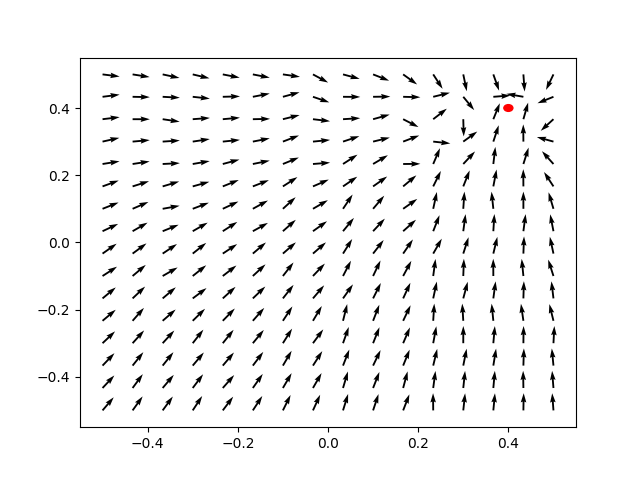

20.842802
13.99228
16.73999
11.545453
15.0466795
17.626156
12.675088
11.77584
11.0129595
9.567046
13.232135
13.215859
8.012696
12.2549515
8.112993
13.415876
10.990797
8.722278
12.713896
9.131762
9.290852
7.5197644
9.536457
14.284459
9.822955
14.42633
12.940989
10.025133
8.6965685
11.761947
10.117433
9.544713
7.308145
7.7177997
8.106773
7.0433726
8.007118
7.7692027
7.326212
13.250961
8.992919
7.30288
8.803419
8.462987
8.885925
6.4473925
5.5310016
6.186536
4.4598436
7.7495956
9.596447
5.6462984
8.220367
12.683027


In [83]:
x, y = torch.meshgrid(torch.linspace(-0.5, 0.5, 16), torch.linspace(-0.5, 0.5, 16))
x = x.flatten()
y = y.flatten()
scale = torch.tensor([field_width, field_hight]).float()

team = torch.stack([x, y], dim=1).unsqueeze(1) * scale
enemy = torch.stack([y, x], dim=1).unsqueeze(1) * scale

ball = torch.tensor([0.4, 0.4]).float().repeat(team.shape[0], 1).unsqueeze(1) * scale

delta = model(team, enemy, ball).squeeze(1).detach().numpy()
# norm_delta = delta / torch.norm(delta, dim=1).unsqueeze(1)


fig, ax = plt.subplots()
# when a click is detected of fig, the mouse position is sent to the model
def on_mose_click(event):
    global delta
    x = event.xdata
    y = event.ydata
    # print(x, y)
    ball = torch.tensor([x, y]).float().repeat(team.shape[0], 1).unsqueeze(1) * scale
    old_delta = delta.copy()
    delta = model(team, enemy, ball).squeeze(1).detach().numpy()
    print(np.linalg.norm(delta - old_delta))
    ax.clear()
    
    ax.quiver(team[:, 0, 0]/scale[0], team[:, 0, 1]/scale[1], delta[:, 0], delta[:, 1])
    circle = plt.Circle((x, y), 0.01, color='r')
    ax.add_artist(circle)
    fig.canvas.draw()


ax.quiver(team[:, 0, 0]/scale[0], team[:, 0, 1]/scale[1], delta[:, 0], delta[:, 1])
circal = plt.Circle(ball[0, 0]/scale, 0.01, color='r')
ax.add_artist(circal)
fig.canvas.mpl_connect('button_press_event', on_mose_click)


